In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

#tf.random.set_seed(2019)
(x,y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

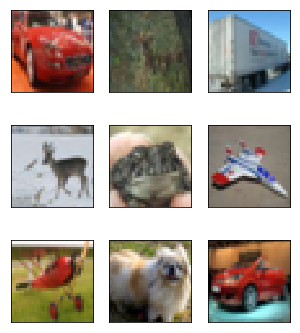

In [3]:
x_train = x
y_train = y
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[5 * i], cmap='Greys')

In [4]:
x_Train, x_Test = x_train / 255.0, x_test / 255.0
#y_train = y_train[...]#, tf.newaxis]
#y_test = y_test[...]#, tf.newaxis]

In [5]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [6]:
x_train = grayscale(x_Train)
x_test = grayscale(x_Test)

In [7]:
x_train.shape

(50000, 32, 32, 1)

In [8]:
x_train = tf.image.resize_images(x_train, size=[28,28])
x_test = tf.image.resize_images(x_test, size=[28,28])

In [9]:
x_train.shape

TensorShape([Dimension(50000), Dimension(28), Dimension(28), Dimension(1)])

In [10]:
sess = tf.Session()
with sess.as_default():
       x_train = x_train.eval()#,x_test = x_text.eval()
       

In [11]:
sess = tf.Session()
with sess.as_default():
       x_test = x_test.eval()
       

In [12]:
x_test.shape

(10000, 28, 28, 1)

In [13]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        print("aqui",input_shape[2],"fin")
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
        print("lalala",inputs_expand)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias = K.sum(inputs_hat * outputs, -1, keepdims=True) #+=
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        print(tuple([None, self.num_capsule, self.dim_vector]))
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    #print(layers.Lambda(squash)(outputs))
    return layers.Lambda(squash)(outputs)

In [14]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)
    #print(x)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

In [15]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [16]:
# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

aqui 8 fin
lalala Tensor("digitcaps/ExpandDims_1:0", shape=(?, ?, 1, 1, 8), dtype=float32)
Instructions for updating:
dim is deprecated, use axis instead
(None, 10, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 

In [17]:
def train(model, data, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})

    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=.49):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, 64, 0.1),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 64),
                        epochs=40,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#
    
    
    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [18]:
y_train = to_categorical(y_train.astype('float32'),10)
y_test = to_categorical(y_test.astype('float32'),10)

In [19]:
train(model=model, data=((x_train, y_train), (x_test, y_test)), 
      epoch_size_frac = 0.5) # do 10% of an epoch (takes too long)

Epoch 1/40
390/390 [==============================] - 427s 1s/step - loss: 0.5035 - out_caps_loss: 0.5034 - out_recon_loss: 0.0525 - out_caps_acc: 0.2024 - val_loss: 0.4519 - val_out_caps_loss: 0.4519 - val_out_recon_loss: 0.0542 - val_out_caps_acc: 0.3180

Epoch 00001: val_loss improved from inf to 0.45191, saving model to weights-01.h5
Epoch 2/40
390/390 [==============================] - 421s 1s/step - loss: 0.4447 - out_caps_loss: 0.4446 - out_recon_loss: 0.0522 - out_caps_acc: 0.3250 - val_loss: 0.4258 - val_out_caps_loss: 0.4258 - val_out_recon_loss: 0.0538 - val_out_caps_acc: 0.3682

Epoch 00002: val_loss improved from 0.45191 to 0.42581, saving model to weights-02.h5
Epoch 3/40
390/390 [==============================] - 420s 1s/step - loss: 0.4287 - out_caps_loss: 0.4286 - out_recon_loss: 0.0517 - out_caps_acc: 0.3586 - val_loss: 0.4085 - val_out_caps_loss: 0.4085 - val_out_recon_loss: 0.0535 - val_out_caps_acc: 0.4031

Epoch 00003: val_loss improved from 0.42581 to 0.40855, sa

In [19]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    import matplotlib.pyplot as plt
    from PIL import Image

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()

--------------------------------------------------
Test acc: 0.66

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


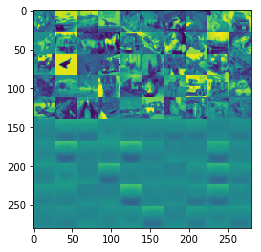

In [21]:
test(model=model, data=(x_test[:100], y_test[:100]))

In [20]:
model2 = model
model2.load_weights('trained_model.h5')

--------------------------------------------------
Test acc: 0.5526

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


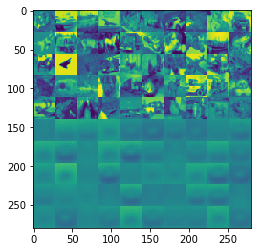

In [21]:
test(model=model2, data=(x_test, y_test))